<a href="https://colab.research.google.com/github/martinfernandoortiz/geoestadistica_unlp/blob/main/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rodrigo Morel - Lizeth Contreras - Martín Fernando Ortiz
#Geoestadística - Maestría de Geomática -- UNLP
## Análisis de datos meteorológicos
### Objetivo General
Aplicar de técnicas de geoestadística para el análisis de datos meteorológicos

### Objetivos Específicos
- Hacer un análisis descriptivo de la información del dataset
- Tratar los datos outliers
- Generar una interpolación para el caso en que tengamos No Datos
- Hacer predicción de datos para un nuevo dataset de estaciones
- Realizar un análisis PCA
- Utilizar alguna técnica de Cluster para generar regiones climatológicas

### Software utilizado
Jupyter / Colab - Python

### Dataset utilizado
Dataset de la cátedra de Geoestadística


In [2]:
#!pip install rasterio geopandas
#!pip install gdal
#!pip install Fiona
#!pip install RISE

In [137]:
# @title
# Carga de librerías
import os

import rise
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import seaborn as sns

import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import box

import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio import features
from rasterio.features import geometry_mask

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans


from sklearn.cluster import KMeans

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import griddata

from joblib import dump, load

from osgeo import gdal as gdal
from osgeo import ogr as ogr
from osgeo import osr

#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# @title
#df_coords = pd.read_csv('/content/drive/My Drive/datasets_colab/final/smn_coord.csv')
df_coords = pd.read_csv('smn_coord.csv')


#df_original = pd.read_csv('/content/drive/My Drive/datasets_colab/final/SMN_estaciones_medias_mensuales_1989_2010.csv')
df_original = pd.read_csv('SMN_estaciones_medias_mensuales_1989_2010.csv')


#country_boundaries = gpd.read_file('/content/drive/My Drive/datasets_colab/final/pais.gpkg')
country_boundaries = gpd.read_file('pais.gpkg')


#archivo = "SMN_estaciones_medias_mensuales_1989_2010.xls"
#df = pd.read_excel(archivo)

Antes de trabajar con el dataset se le hizo una limpieza a los datos de coordenadas que éste poseia dado que la localización de las estaciones no era correcta. La limpieza se realizó desde QGIS.

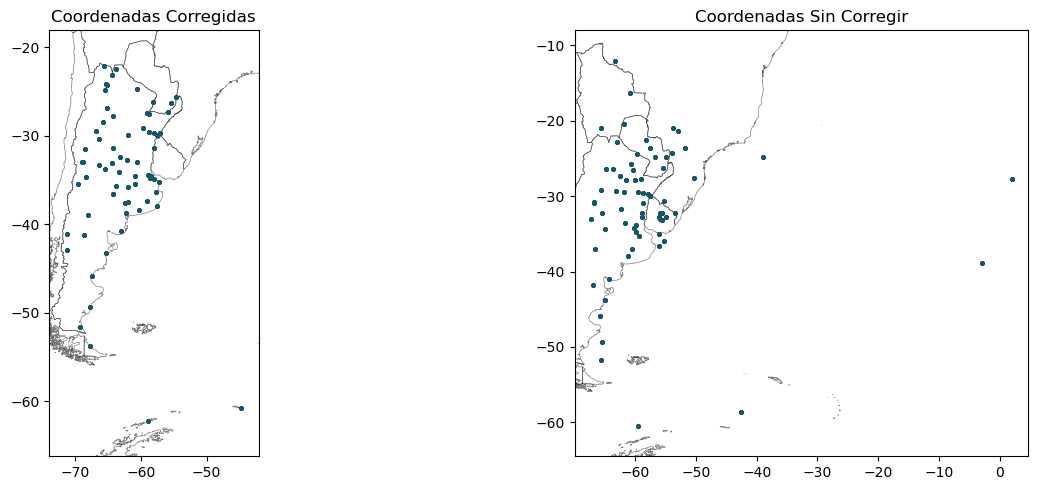

In [6]:
# @title
pais= country_boundaries
# Supongamos que tienes dos GeoDataFrames llamados gdf y gdf1


gdf = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['long'], df_coords['lat']), crs='EPSG:4326')
gdf1 = gpd.GeoDataFrame(df_original, geometry=gpd.points_from_xy(df_original['long'], df_original['lat']), crs='EPSG:4326')

# Crear el mapa con dos subgráficos (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# ---- Plotear el primer DataFrame (gdf) ----
ax = axs[0]  # Seleccionar el primer subgráfico

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf.total_bounds
margin_scale = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al subgráfico
ax.set_title("Coordenadas Corregidas")

# ---- Plotear el segundo DataFrame (gdf1) ----
ax = axs[1]  # Seleccionar el segundo subgráfico

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf1.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf1.total_bounds
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al subgráfico
ax.set_title("Coordenadas Sin Corregir")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el mapa
plt.show()

Vamos a corregir las coordenadas para ya tener bien el DataFrame

In [7]:
# @title
df_coords_unique = df_coords[['Estacion', 'lat', 'long']].drop_duplicates()
# Combina los DataFrames utilizando la columna 'estacion'
df_combinado = pd.merge(df_original, df_coords_unique, on='Estacion', suffixes=('', '_df1'))

# Actualiza los valores incorrectos en df con los valores correctos de df1
df_combinado['lat'] = df_combinado['lat_df1']
df_combinado['long'] = df_combinado['long_df1']

# Elimina las columnas innecesarias
df = df_combinado.iloc[:, np.r_[0:15]]



In [8]:
# @title
df_combinado.shape[0]

840

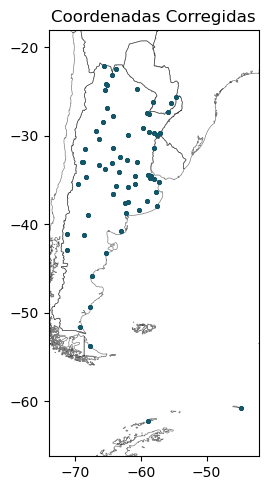

In [9]:
# @title
pais= country_boundaries
# Supongamos que tienes dos GeoDataFrames llamados gdf y gdf1


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']), crs='EPSG:4326')

# Crear el mapa con un solo subgráfico
fig, ax = plt.subplots(figsize=(15, 5))

# Plotear la capa de polígonos (límites del país)
pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Plotear la capa de puntos con colores basados en alguna columna
gdf.plot(ax=ax, color='#145769', marker='o', markersize=5)

# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = gdf.total_bounds
margin_scale = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)

# Añadir título al gráfico
ax.set_title("Coordenadas Corregidas")

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el mapa
plt.show()

In [10]:
# @title
df = df.applymap(lambda x: np.NaN if x == "S/D" else x)

Estructura General del Dataset
Con los métodos XXX , podemos ver la estructura general del dataset (largo,nombre y tipo de columnas) cantidad de Nodatos, tipos de Datos, etc.

El dataset contiene información meteorológica de las estaciones XXX para cada mes

boxplot de todos......

In [11]:
# @title
#transformamos a númerico

df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)","Precipitacion_(mm)",
    "Frecuencia_dias_Precipitacion_>0.1_mm"]] = df[["Temperatura_(C)","Temperatura_minima_(C)", "Humedad_relativa_(%)","Velocidad_del_Viento_(km/h)",
                                                    "Nubosidad_total_(octavos)","Precipitacion_(mm)","Frecuencia_dias_Precipitacion_>0.1_mm"]].astype(float)


In [12]:
# @title
df.dtypes #tipo de dato por columna
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             840 non-null    int64  
 1   Estacion                               840 non-null    object 
 2   mes                                    840 non-null    object 
 3   lat                                    840 non-null    float64
 4   long                                   840 non-null    float64
 5   Altura_(m)                             840 non-null    int64  
 6   Numero                                 840 non-null    int64  
 7   Temperatura_(C)                        838 non-null    float64
 8   Temperatura_maxima_(C)                 840 non-null    float64
 9   Temperatura_minima_(C)                 818 non-null    float64
 10  Humedad_relativa_(%)                   812 non-null    float64
 11  Veloci

Estadística descriptiva del Dataset

In [13]:
# @title
df.iloc[:, np.r_[7:15]].describe()

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
count,838.000000,840.000000,818.000000,812.000000,708.000000,826.000000,807.000000,807.000000
mean,15.871838,22.411667,10.225428,68.044581,12.456497,3.817191,69.334944,6.756877
std,6.996565,7.443672,6.775667,10.828241,5.390830,0.764862,52.093688,2.763202
min,-11.600000,-7.300000,-16.800000,30.100000,3.000000,1.400000,0.000000,0.000000
25%,11.200000,18.000000,5.525000,62.175000,8.700000,3.400000,23.400000,4.750000
50%,16.300000,23.100000,10.700000,70.200000,11.300000,3.700000,59.000000,7.100000
75%,21.700000,28.300000,15.475000,76.325000,14.800000,4.100000,108.600000,8.700000
max,27.900000,35.100000,22.300000,88.100000,30.800000,7.500000,237.000000,16.300000


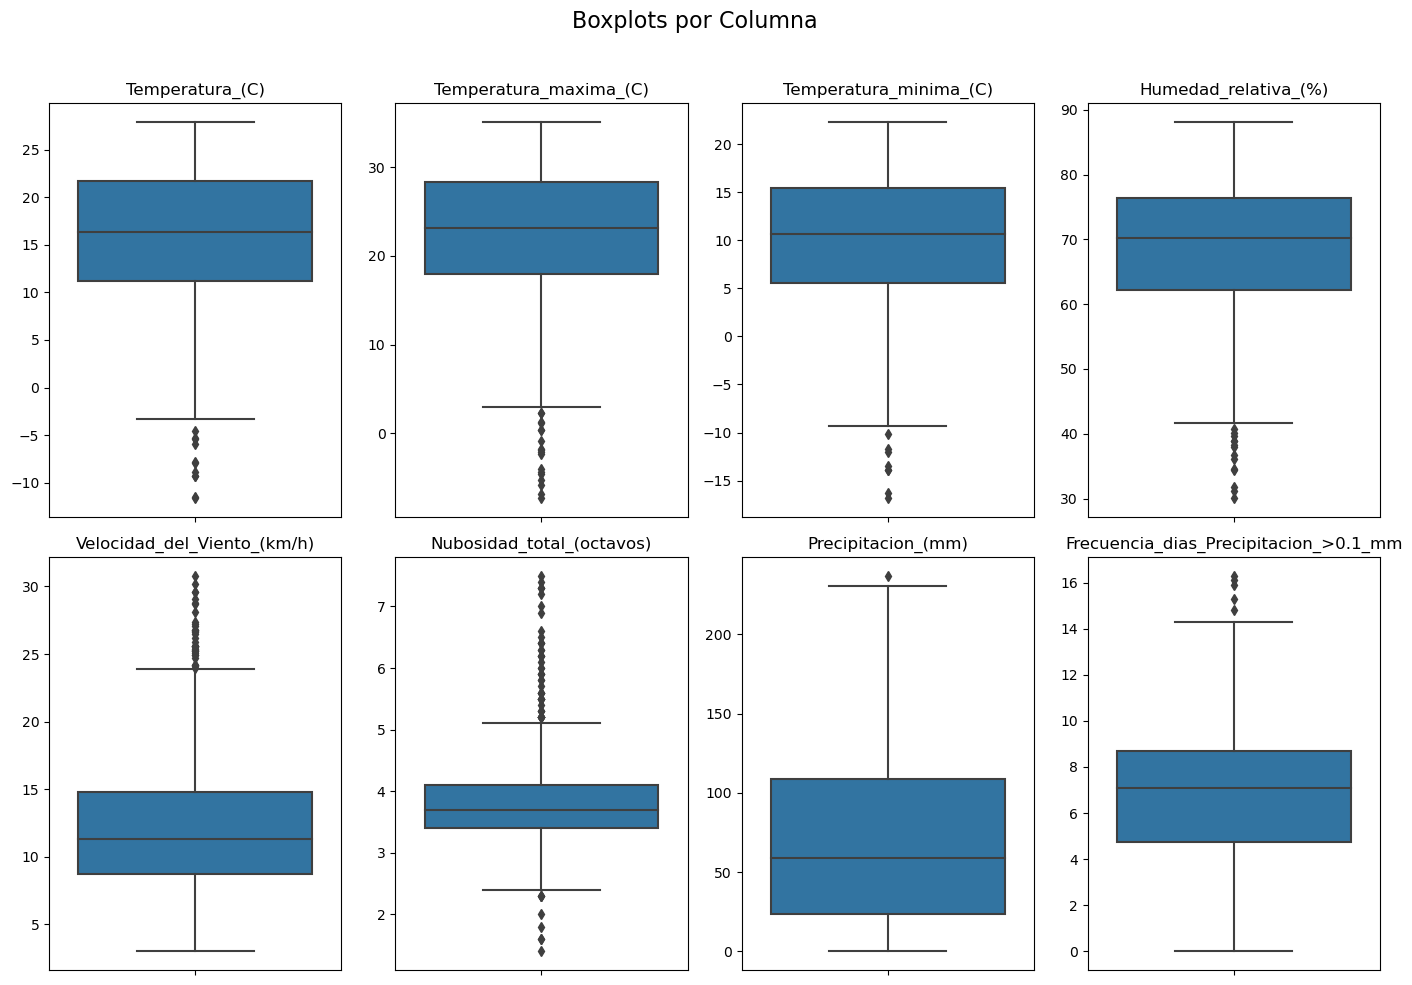

In [14]:
# @title
df_boxplot = df.iloc[:, np.r_[7:15]]
columns_for_boxplot = df_boxplot.columns

# Crear subgráficos para cada columna
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 10))
fig.suptitle("Boxplots por Columna", fontsize=16)

# Iterar sobre las columnas y crear los boxplots
for i, col in enumerate(columns_for_boxplot):
    row = i // 4
    col_position = i % 4  # Cambiado el nombre de la variable
    sns.boxplot(y=df_boxplot[col], ax=axs[row, col_position], orient='v', whis=1.5)  # Especifica la orientación vertical
    axs[row, col_position].set_title(col)
    axs[row, col_position].set(xlabel=None, ylabel=None)  # Eliminar etiquetas de los ejes

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


A partír de ésto surge el interrogante de cómo manejar los outliers. ¿Los cambiamos por la media? Los cambiamos por la media de la estación?

Es interesante plantear si esos outliers son errores en las mediciones o tienen que ver con las condiciones geográficas que puede haber en el lugar. Ejemplo de ésto las temperaturas mínimas en las bases antarticas

Vamos a visualizar el porcentaje de datos por fuera de los bigotes del boxplot, cuanto este esta definido como Q1 − 1.5 ∗ RI y Q3 + 1.5 ∗ RI.


In [15]:
# @title
def f(row):
    if row[colname] < lower_lim:
        val = 'Es Outlier'
    elif row[colname] > upper_lim:
        val = 'Es Outlier'
    else:
        val = 'No es Outlier'
    return val

In [16]:
# @title
outliers_df = pd.DataFrame()
#type(estadisticos)
rango= np.r_[7:15]
y= 0
df_out = df
for x in rango:

    colname = df_out.columns[x]
   # print(colname)
    Q1 = df_out[colname].quantile(0.25)
    Q3 = df_out[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    df_out['outlier'] = df_out.apply(f, axis=1)


    porcentaje =df_out['outlier'].value_counts(normalize=True).rename(colname)

    lower_lim_ = pd.Series({"lower_lim":lower_lim}).rename(colname)
    upper_lim_ = pd.Series({"upper_lim":upper_lim}).rename(colname)

    porcentaje= pd.concat([porcentaje, lower_lim_], axis=0)
    porcentaje= pd.concat([porcentaje, upper_lim_], axis=0)
   # porcentaje = porcentaje.append(lower_lim_).rename(colname)
   # porcentaje = porcentaje.append(upper_lim_).rename(colname)

   # print(porcentaje)
    outliers_df = pd.concat ([outliers_df,porcentaje], axis=1)
    #outliers_df = outliers_df.append(porcentaje,ignore_index=False)
    #print(outliers_df)

outliers_df

,Temperatura_(C),Temperatura_maxima_(C),Temperatura_minima_(C),Humedad_relativa_(%),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Precipitacion_(mm),Frecuencia_dias_Precipitacion_>0.1_mm
No es Outlier,0.986905,0.978571,0.990476,0.983333,0.958333,0.933333,0.99881,0.994048
Es Outlier,0.013095,0.021429,0.009524,0.016667,0.041667,0.066667,0.00119,0.005952
lower_lim,-4.550000,2.550000,-9.400000,40.950000,-0.450000,2.350000,-104.40000,-1.175000
upper_lim,37.450000,43.750000,30.400000,97.550000,23.950000,5.150000,236.40000,14.625000


Vamos a visualizar la cantidad de no datos

A continuación vamos a visualizar

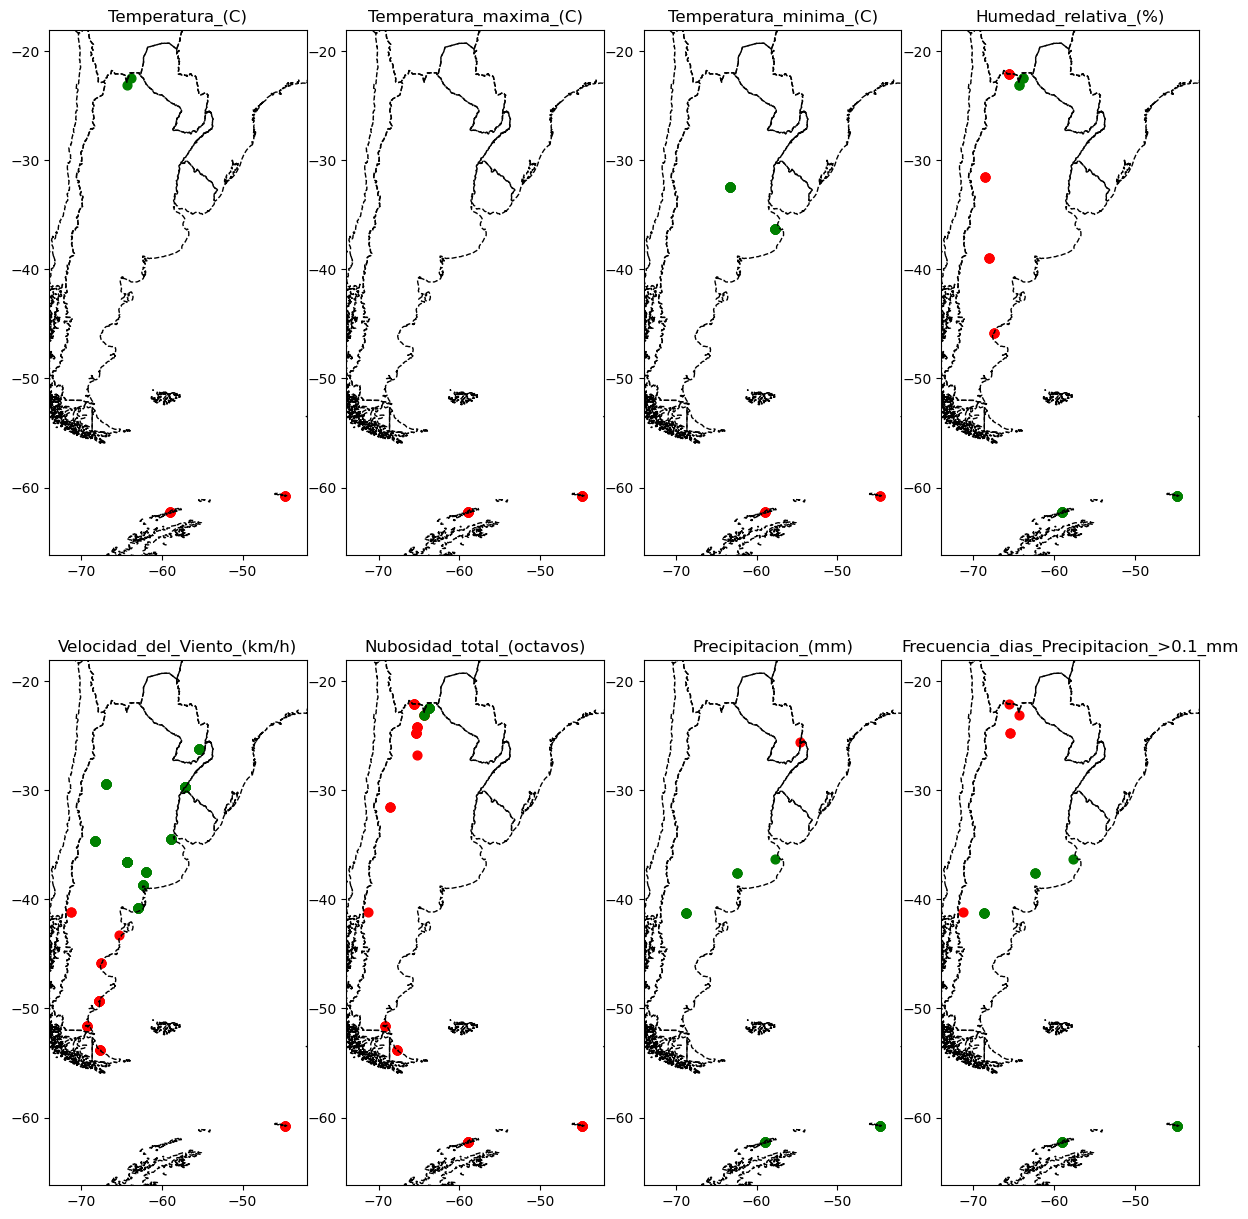

In [77]:
# @title
def f(row):
    if row[colname] < lower_lim:
        val = 'Es Outlier'
    elif row[colname] > upper_lim:
        val = 'Es Outlier'
    else:
        val = 'No es Outlier'
    return val

outliers_df = pd.DataFrame()

rango = np.r_[7:15]
y = 0
df_out = df

columnas_interes = df.columns[7:15]

# Calcular los límites ajustados con un margen del 10%
x_min, x_max = df['long'].min(), df['long'].max()
y_min, y_max = df['lat'].min(), df['lat'].max()
x_range = x_max - x_min
y_range = y_max - y_min
margin_scale = 0.1
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range

# Crear una figura y subgráficos en dos filas y cuatro columnas con ajustes de tamaño y espacio
fig, axs = plt.subplots(2, 4, figsize=(15, 15), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'wspace': 0.1})



# Iterar sobre las columnas de interés y crear un gráfico de dispersión para cada una
for i, col in enumerate(columnas_interes, start=1):
    row_index = (i - 1) // 4
    col_index = (i - 1) % 4

    country_boundaries.boundary.plot(ax=axs[row_index, col_index], color='black', linewidth=1, linestyle='dashed')

    colname = df_out.columns[i + 6]  # Ajustar índice
    Q1 = df_out[colname].quantile(0.25)
    Q3 = df_out[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR

    df_out['outlier'] = df_out.apply(f, axis=1)
    df_filtrado = df_out.loc[df_out['outlier'] == 'Es Outlier']

    axs[row_index, col_index].scatter(df_filtrado['long'], df_filtrado['lat'], color='red', s=40, label='Outliers')

    df_nan = df_out[df_out[colname].isna()]
    axs[row_index, col_index].scatter(df_nan['long'], df_nan['lat'], color='green', s=40, label='Nan')

    axs[row_index, col_index].set_xlim(x_min_adjusted, x_max_adjusted)
    axs[row_index, col_index].set_ylim(y_min_adjusted, y_max_adjusted)

    axs[row_index, col_index].set_title(colname)

# Mostrar los gráficos
plt.show()


# Tratamiento de Outliers

Aquellos valores Outliers vamos a asignarles el valor medio de la estación

In [78]:
# @title
def reemplazar_outlier_con_mediana(valor, lower_lim, upper_lim, mediana):
    if valor < lower_lim or valor > upper_lim:
        return mediana
    else:
        return valor

median_values = df.median()

# 2. Itera sobre las columnas de interés y reemplaza los outliers con la mediana
rango = np.r_[7:15]
df_median = df.copy()  # Hacemos una copia para no modificar el DataFrame original

for col_index in rango:
    col_name = df_median.columns[col_index]

    Q1 = df_median[col_name].quantile(0.25)
    Q3 = df_median[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR

    # Calcular la mediana para la columna actual
    mediana_actual = median_values[col_name]

    # Aplicar la función a toda la columna
    df_median[col_name] = df_median[col_name].apply(
        lambda x: reemplazar_outlier_con_mediana(x, lower_lim, upper_lim, mediana_actual)
    )


/tmp/ipykernel_741/3901694265.py:8: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_values = df.median()


#Interpolación
Como vimos anteriormente el dataset tiene registros sin dato. A continuación vamos a realizar dos métodos de interpolación para poder tener esas mediciones.
Vamos a utilizar el mètodo IDW y KNN.

In [79]:
# @title
#Funciones para interpolar y graficar
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

def plot(x,y,z, grid, Isocontornos = None):
    """ Plot the input points and the result """
    extent = (x.min(), x.max(), y.min(), y.max() )
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian')

    if Isocontornos != None:
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7,s=20)
    plt.colorbar()



def plot(x, y, z, grid, Isocontornos=None, country_boundaries=None):
    """ Plot the input points, result, and country boundaries """
    extent = (x.min(), x.max(), y.min(), y.max())
    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian',aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')

    # Mostrar los límites del país como referencia
    if country_boundaries is not None:
        #country_boundaries.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')
    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

Vamos a hacer el promedio de cada estación antes de interpolar

In [80]:
# @title
df_filtered = df_median[['lat', 'long', 'Temperatura_(C)']].dropna()
df_filtered = df_filtered.groupby(['lat', 'long']).mean().reset_index()


y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values


#df_na=df_median[['lat', 'long', 'Temperatura_(C)']]
#df_na= df_na.isna().any(axis=1)


df_na = df_median[['lat', 'long', 'Temperatura_(C)']][df_median[['lat', 'long', 'Temperatura_(C)']].isna().any(axis=1)]
y_na = df_na.lat.values
x_na = df_na.long.values

In [81]:
# @title
#Armado de grilla
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

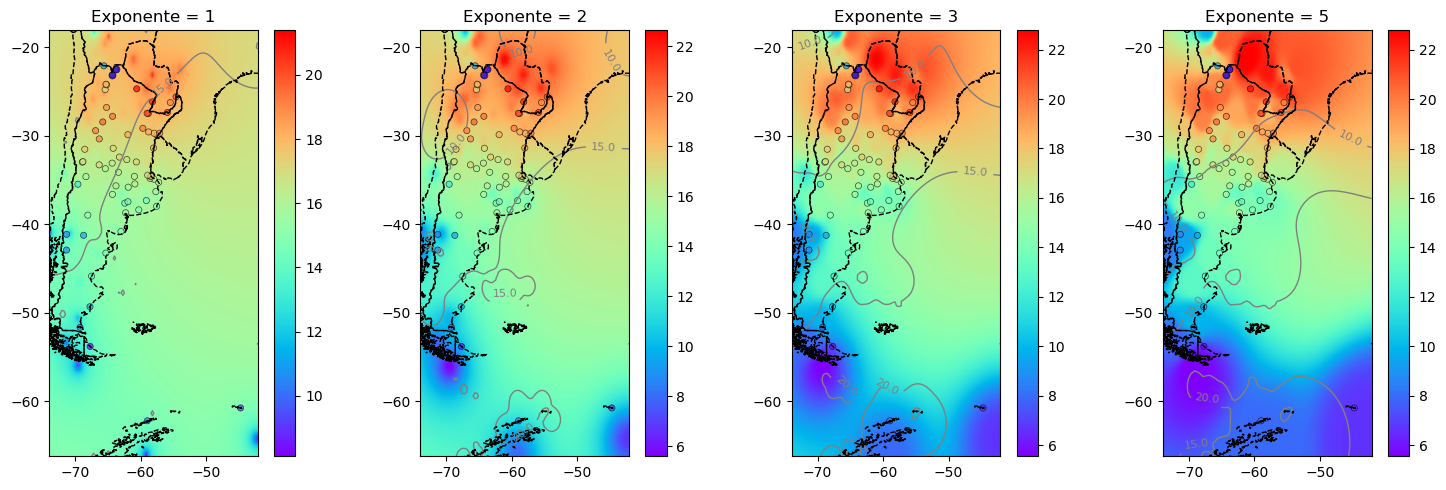

In [82]:
# @title

# Definir los diferentes valores de exponente
exponentes = [1,2,3,5]

# Crear subgráficos en una fila
plt.figure(figsize=(15, 5))

for i, exponente in enumerate(exponentes, 1):
    # Calcular la grilla interpolada
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    # Crear un subplot en la posición i
    plt.subplot(1, len(exponentes), i)

    # Calcular los límites ajustados con un margen del 10%
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_scale = 0.1
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
               cmap='rainbow', interpolation='gaussian', aspect='auto')
    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Agregar isocontornos si se proporcionan
    Isocontornos = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                               levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)
    plt.scatter(x_na, y_na,  color='blue', edgecolors='black', linewidths=0.5, alpha=0.7, s=25)

    # Agregar una barra de color para la escala de colores
#    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Agregar un título que incluya el valor actual de exponente
    plt.title(f'Exponente = {exponente}')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Vamos a ver el gráfico con más detalle

In [84]:
# @title
def plot_with_country1(x, y, z, grid1, Isocontornos=None, country_boundaries=None, margin_scale=.1):
    """ Plot the input points, result, and country boundaries with a specified margin """


   # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted_grid = x_min - margin_scale * x_range
    x_max_adjusted_grid = x_max + margin_scale * x_range
    y_min_adjusted_grid = y_min - margin_scale * y_range
    y_max_adjusted_grid = y_max + margin_scale * y_range






    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x_na.min(), x_na.max()
    y_min, y_max = y_na.min(), y_na.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted_grid, x_max_adjusted_grid, y_min_adjusted_grid, y_max_adjusted_grid),
                    cmap='rainbow', interpolation='gaussian', aspect='auto')
    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                           levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    #plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Quitar etiquetas de los ejes x e y
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('')
    #ax.set_ylabel('')


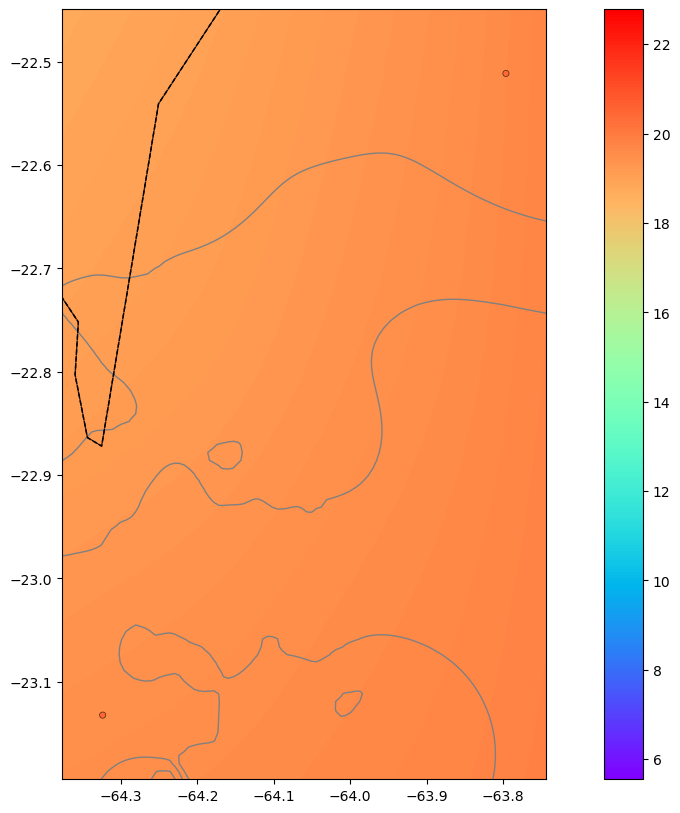

In [24]:
# @title
_exponente = 1
grid1 = simple_idw(x,y,z,xi,yi, power = exponente )
grid1 = grid1.reshape((ny, nx))
plot_with_country1(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)
plt.show()

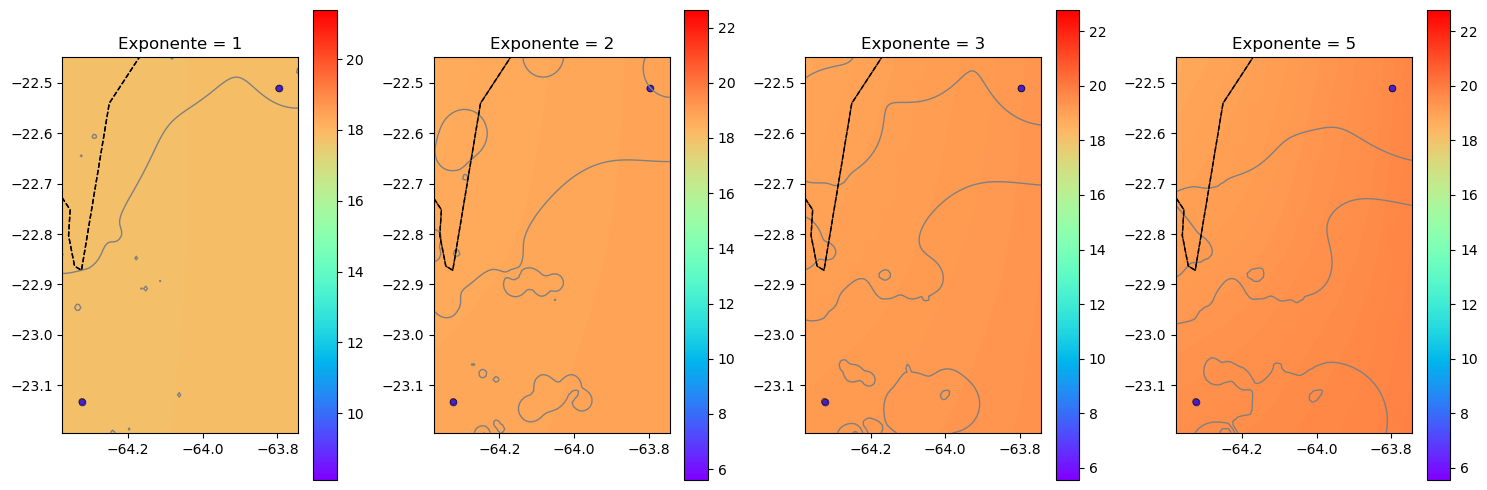

In [85]:
# @title

# Definir los diferentes valores de exponente
exponentes = [1,2,3,5]

# Crear subgráficos en una fila
plt.figure(figsize=(15, 5))

for i, exponente in enumerate(exponentes, 1):
    # Calcular la grilla interpolada
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    # Crear un subplot en la posición i
    plt.subplot(1, len(exponentes), i)

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted_grid = x_min - margin_scale * x_range
    x_max_adjusted_grid = x_max + margin_scale * x_range
    y_min_adjusted_grid = y_min - margin_scale * y_range
    y_max_adjusted_grid = y_max + margin_scale * y_range






    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x_na.min(), x_na.max()
    y_min, y_max = y_na.min(), y_na.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min


    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted_grid, x_max_adjusted_grid, y_min_adjusted_grid, y_max_adjusted_grid),
               cmap='rainbow', interpolation='gaussian', aspect='auto')
    plt.colorbar(norm=Normalize(vmin=grid.min(), vmax=grid.max()))

    # Agregar isocontornos si se proporcionan
    Isocontornos = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                               levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)
    plt.scatter(x_na, y_na,  color='blue', edgecolors='black', linewidths=0.5, alpha=0.7, s=25)

    # Agregar una barra de color para la escala de colores
    #plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Agregar un título que incluya el valor actual de exponente
    plt.title(f'Exponente = {exponente}')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Utilizando el método IDW vemos que al aumentar el exponente aumenta el contraste en la representaciòn de la grilla. Es decir, con valores más altos de exponente la distribución de los valores tiene mayor varianza.[link text](https://)

Para pasar de grilla a raster

In [86]:
# @title
# Transformo la grilla a Raster

from shapely.geometry import box
# Definir las coordenadas extremas
    # Calcular los límites ajustados con un margen del 10%
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
x_range = x_max - x_min
y_range = y_max - y_min
margin_scale = 0.1
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range

xmin, xmax, ymin, ymax = x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted

# Crear un GeoDataFrame ficticio con una geometría de tipo caja que cubre el área de interés
geometry = box(xmin, ymin, xmax, ymax)
gdf = gpd.GeoDataFrame(geometry=[geometry])

# Obtener el sistema de referencia espacial del GeoDataFrame
desired_crs = 'EPSG:4326'

# Ancho y alto del raster
width = grid.shape[1]
height = grid.shape[0]

# Establecer la resolución del raster
res = (width / grid.shape[1], height / grid.shape[0])

# Crear un objeto de transformación para definir la relación entre las coordenadas del mundo y los píxeles del raster
transform = from_origin(x_min_adjusted, y_max_adjusted, res[0], res[1])

# Definir el perfil del raster
profile = {
    'driver': 'GTiff',
    'count': 1,  # Número de bandas
    'dtype': 'float32',  # Tipo de datos
    'width': width,  # Ancho del raster
    'height': height,  # Altura del raster
    'crs': desired_crs,  # Sistema de referencia espacial
    'transform': transform,  # Transformación
    'compress': 'lzw',  # Compresión
    'nodata': -9999,  # Valor para los nodata
}

# Escribir el raster en un archivo GeoTIFF
#output_file = '/content/drive/My Drive/datasets_colab/final/raster.tif'
output_file = 'raster.tif'

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(grid, 1)

# Crear una máscara de geometría válida
#mask = geometry_mask(gdf.geometry, transform=dst.transform, out_shape=(dst.height, dst.width), invert=True)

# Aplicar la máscara al raster
#grid1_masked = np.ma.array(grid, mask=mask)

# Escribir el nuevo raster con la máscara aplicada
#output_masked_file = '/content/drive/My Drive/datasets_colab/final/raster_masked.tif'
#with rasterio.open(output_masked_file, 'w', **profile) as dest:
#    dest.write(grid1_masked, 1)

Para interpolar puntos con raster

In [94]:
df_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             840 non-null    int64  
 1   Estacion                               840 non-null    object 
 2   mes                                    840 non-null    object 
 3   lat                                    840 non-null    float64
 4   long                                   840 non-null    float64
 5   Altura_(m)                             840 non-null    int64  
 6   Numero                                 840 non-null    int64  
 7   Temperatura_(C)                        838 non-null    float64
 8   Temperatura_maxima_(C)                 840 non-null    float64
 9   Temperatura_minima_(C)                 818 non-null    float64
 10  Humedad_relativa_(%)                   812 non-null    float64
 11  Veloci

In [95]:
from shapely.geometry import Point

gdf_median = gpd.GeoDataFrame(df_median, geometry=gpd.points_from_xy(df_median['long'], df_median['lat']), crs='EPSG:4326')

def raster_values_at_points(raster_path, points_gdf: gpd.GeoDataFrame, column_name: str) -> gpd.GeoDataFrame:
    new_gdf = points_gdf.copy()  # do not change the original GeoDataFrame

    # Extracting coordinates from the GeoSeries
    coords = [(point.x, point.y) for point in points_gdf.geometry]

    with rasterio.open(raster_path) as src:
        # Sample raster values at coordinates
        new_gdf[column_name] = [x[0] for x in src.sample(coords)]

    return new_gdf

# Example usage
raster_path = 'raster.tif'
points_gdf = gdf_median

raster_values_gdf = raster_values_at_points(raster_path, points_gdf, "rastervalue")
print(raster_values_gdf.head())

   Unnamed: 0   Estacion    mes        lat       long  Altura_(m)  Numero  \
0           0  LA QUIACA    ene -22.107729 -65.604696        3459   87007   
1           1  LA QUIACA    feb -22.107729 -65.604696        3459   87007   
2           2  LA QUIACA    mar -22.107729 -65.604696        3459   87007   
3           3  LA QUIACA  abril -22.107729 -65.604696        3459   87007   
4           4  LA QUIACA   mayo -22.107729 -65.604696        3459   87007   

   Temperatura_(C)  Temperatura_maxima_(C)  Temperatura_minima_(C)  \
0             12.8                    20.1                     7.4   
1             12.5                    19.9                     7.0   
2             12.4                    19.9                     6.3   
3             10.9                    19.7                     2.8   
4              6.9                    17.3                    -3.0   

   Humedad_relativa_(%)  Velocidad_del_Viento_(km/h)  \
0                  65.3                          6.9   
1   

Por último vamos a asignarle los valores interpolados a los nan.

In [97]:
# @title
raster_values_gdf['Temperatura_(C)'] = np.where(np.isnan(raster_values_gdf['Temperatura_(C)']),
                                                 raster_values_gdf['rastervalue'],
                                                 raster_values_gdf['Temperatura_(C)'])
raster_values_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Unnamed: 0                             840 non-null    int64   
 1   Estacion                               840 non-null    object  
 2   mes                                    840 non-null    object  
 3   lat                                    840 non-null    float64 
 4   long                                   840 non-null    float64 
 5   Altura_(m)                             840 non-null    int64   
 6   Numero                                 840 non-null    int64   
 7   Temperatura_(C)                        840 non-null    float64 
 8   Temperatura_maxima_(C)                 840 non-null    float64 
 9   Temperatura_minima_(C)                 818 non-null    float64 
 10  Humedad_relativa_(%)                   812 non-null   

Ahora hacemos un loop para todos los campos: primero la función y despues el loop. vamos a guardar un shape con todos los resultados

In [102]:
# @title
#################################################
#################################################
### Interpolar
#################################################
#################################################

# Read points from shapefile


def raster_values_at_points(raster_path, points_gdf: gpd.GeoDataFrame, column_name: str) -> gpd.GeoDataFrame:
    new_gdf = points_gdf.copy()  # do not change the original GeoDataFrame

    # Extracting coordinates from the GeoSeries
    coords = [(point.x, point.y) for point in points_gdf.geometry]

    with rasterio.open(raster_path) as src:
        # Sample raster values at coordinates
        new_gdf[column_name] = [x[0] for x in src.sample(coords)]

    return new_gdf


rango = np.r_[7:15]

for x in rango:
    colname = df_median.columns[x]
    sanitized_colname = colname.replace('(', '').replace(')', '').replace('/', '_')
#    output_file = f'/content/drive/My Drive/datasets_colab/final/r_{sanitized_colname}.tif'
    output_file = f'r_{sanitized_colname}.tif'

    print(f"Intentando crear: {output_file}")
    try:
        with rasterio.open(output_file, 'w', **profile) as dst:
            # Puedes opcionalmente escribir datos en el raster si es necesario
            data = np.zeros((height, width), dtype=np.float32)
            dst.write(data, 1)
        print(f"Archivo creado exitosamente: {output_file}")
    except Exception as e:
        print(f"Error al crear el archivo: {e}")



Intentando crear: r_Temperatura_C.tif
Archivo creado exitosamente: r_Temperatura_C.tif
Intentando crear: r_Temperatura_maxima_C.tif
Archivo creado exitosamente: r_Temperatura_maxima_C.tif
Intentando crear: r_Temperatura_minima_C.tif
Archivo creado exitosamente: r_Temperatura_minima_C.tif
Intentando crear: r_Humedad_relativa_%.tif
Archivo creado exitosamente: r_Humedad_relativa_%.tif
Intentando crear: r_Velocidad_del_Viento_km_h.tif
Archivo creado exitosamente: r_Velocidad_del_Viento_km_h.tif
Intentando crear: r_Nubosidad_total_octavos.tif
Archivo creado exitosamente: r_Nubosidad_total_octavos.tif
Intentando crear: r_Precipitacion_mm.tif
Archivo creado exitosamente: r_Precipitacion_mm.tif
Intentando crear: r_Frecuencia_dias_Precipitacion_>0.1_mm.tif
Archivo creado exitosamente: r_Frecuencia_dias_Precipitacion_>0.1_mm.tif


In [103]:
# @title
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import box

gdf_median = gpd.GeoDataFrame(df_median, geometry=gpd.points_from_xy(df_median['long'], df_median['lat']), crs='EPSG:4326')

#Itera en este rango de columnas
rango = np.r_[7:15]

#Creo en GDF solo para la interpolación
coord_columns = ['geometry']  # Agrega más columnas si es necesario

# Crear un nuevo GeoDataFrame solo con las columnas de coordenadas
gdf_coords = gdf_median[coord_columns].copy()
gdf_coords_entero = gdf_coords.copy()

df_idw = df_median
final = df_median
rango_n = ['a','b','c','d','e','f','g','h',]
yy=0

for x in rango:
    colname = df_idw.columns[x]
    df_filtered = df_idw[['lat', 'long', colname]].dropna()
    df_filtered = df_filtered.groupby(['lat', 'long']).mean().reset_index()

    y = df_filtered.lat.values
    x = df_filtered.long.values
    z = df_filtered[colname].values

    nx, ny = 100, 100
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.max(), y.min(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    exponente = 3
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_scale = 0.1
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    xmin, xmax, ymin, ymax = x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted
    geometry = box(xmin, ymin, xmax, ymax)
    gdf = gpd.GeoDataFrame(geometry=[geometry])


    # Obtener el sistema de referencia espacial del GeoDataFrame
    desired_crs = 'EPSG:4326'

    # Ancho y alto del raster
    width = grid.shape[1]
    height = grid.shape[0]

    # Establecer la resolución del raster
    res = (width / grid.shape[1], height / grid.shape[0])

    # Crear un objeto de transformación para definir la relación entre las coordenadas del mundo y los píxeles del raster
    transform = from_origin(x_min_adjusted, y_max_adjusted, res[0], res[1])

    # Definir el perfil del raster
    profile = {
        'driver': 'GTiff',
        'count': 1,  # Número de bandas
        'dtype': 'float32',  # Tipo de datos
        'width': width,  # Ancho del raster
        'height': height,  # Altura del raster
        'crs': desired_crs,  # Sistema de referencia espacial
        'transform': transform,  # Transformación
        'compress': 'lzw',  # Compresión
        'nodata': -9999,  # Valor para los nodata
    }

#    patio = '/content/drive/My Drive/datasets_colab/final/r_'
    patio = 'r_'

    colname
    formato='.tif'

    # Escribir el raster en un archivo GeoTIFF

    #colname = df_median.columns[x]
    sanitized_colname = colname.replace('(', '').replace(')', '').replace('/', '_')
#    output_file = f'/content/drive/My Drive/datasets_colab/final/r_{sanitized_colname}.tif'
    output_file = f'r_{sanitized_colname}.tif'

    with rasterio.open(output_file, 'w', **profile) as dst:
         # Puedes opcionalmente escribir datos en el raster si es necesario
             data = np.zeros((height, width), dtype=np.float32)
             dst.write(grid, 1)


    #output_file = patio+colname+formato
    #with rasterio.open(output_file, 'w', **profile) as dst:
    #  dst.write(grid, 1)



    #output_directory = '/content/drive/My Drive/datasets_colab/final/'
    #format = '.tif'
    raster_path = output_file
    print(raster_path)

    gdf_coords = raster_values_at_points(raster_path, gdf_median, 'raster_value')
    #gdf_coords_entero= pd.merge(gdf_coords_entero,gdf_coords,left_index=True, right_index=True)
    gdf_coords[colname] = np.where(np.isnan(gdf_coords[colname]),
                                           gdf_coords['raster_value'],
                                           gdf_coords[colname])



    # Asegúrate de que los índices coincidan correctamente (en este caso, estamos utilizando 'ID')
    gdf_median.set_index(gdf_median.index, inplace=True)
    gdf_coords.set_index(gdf_coords.index, inplace=True)

    # Reemplazar la columna 'Nombre' en df1 con la columna 'Nueva_Columna' de df2
    gdf_median[colname] = gdf_coords[colname]


# Especifica la ruta y el nombre del archivo Shapefile de salida
#output_shapefile = '/content/drive/My Drive/datasets_colab/final/gdf_median.gpkg'
output_shapefile = 'gdf_median.gpkg'

# Exporta el GeoDataFrame a Shapefile
gdf_median.to_file(output_shapefile)

r_Temperatura_C.tif
r_Temperatura_maxima_C.tif
r_Temperatura_minima_C.tif
r_Humedad_relativa_%.tif
r_Velocidad_del_Viento_km_h.tif
r_Nubosidad_total_octavos.tif
r_Precipitacion_mm.tif
r_Frecuencia_dias_Precipitacion_>0.1_mm.tif


In [106]:
# @title
gdf_median.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Unnamed: 0                             840 non-null    int64   
 1   Estacion                               840 non-null    object  
 2   mes                                    840 non-null    object  
 3   lat                                    840 non-null    float64 
 4   long                                   840 non-null    float64 
 5   Altura_(m)                             840 non-null    int64   
 6   Numero                                 840 non-null    int64   
 7   Temperatura_(C)                        840 non-null    float64 
 8   Temperatura_maxima_(C)                 840 non-null    float64 
 9   Temperatura_minima_(C)                 840 non-null    float64 
 10  Humedad_relativa_(%)                   840 non-null   

# KNN para calcular valores de nuevas estaciones

In [107]:
# @title
############################################
#
#     Tomamos la "Temperatura# como ejemplo
#
################################################


df_filtered = df_median.groupby(['lat', 'long']).mean().reset_index()

df_filtered = df_filtered[['lat', 'long', 'Temperatura_(C)']].dropna()


coords_temp = df_filtered[['long','lat']].values
value_temp = df_filtered['Temperatura_(C)'].values

############################################
#
#     Separamos en train y test los datos
#
################################################

X_train, X_test, y_train, y_test = train_test_split(coords_temp, value_temp, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only on X_train

# Scale both X_train and X_test
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


/tmp/ipykernel_741/4275380309.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_filtered = df_median.groupby(['lat', 'long']).mean().reset_index()


In [108]:
# @title
############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 10

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=neighbors, weights= 'distance')
regressor.fit(X_train, y_train)



y_pred = regressor.predict(X_test)



############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
#knn_regressor.fit(coords_temp_train, value_temp_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
reg_score=regressor.score(X_test, y_test)
print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'reg score: {reg_score}')

mae: 1.3028427589319729
mse: 2.5060905701905893
rmse: 1.5830636658677342
reg score: 0.8392934599748496


Al hacer el modelo con un k=20 vemos que las métricas no son muy buenas. Vamos a probar de ver cómo cambia el MSE con diferentes valores de k

mae = (1/n) * ∑_{i=1}^{n} |Actual - Predicted|

---



mse = ∑_{i=1}^{D} (Actual - Predicted)^2

rmse = sqrt{ ∑_{i=1}^{D} (Actual - Predicted)^2 }

In [109]:
# @title
error = []

# Calculating MAE error for K values between 1 and 39
for i in range(1, 40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    mae = mean_absolute_error(y_test, pred_i)
    error.append(mae)

Text(0, 0.5, 'Mean Absolute Error')

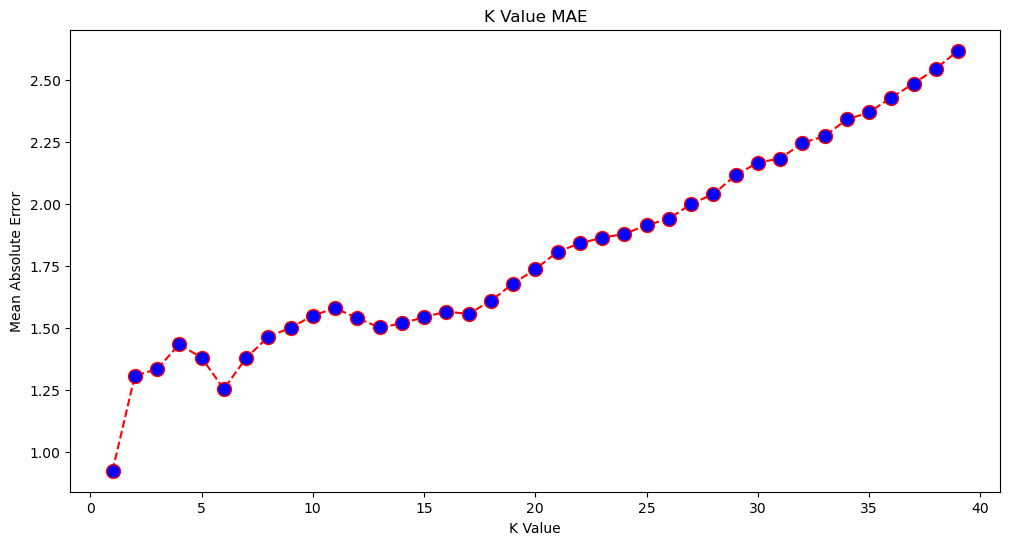

In [110]:
# @title

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red',
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

Text(0, 0.5, 'Mean Absolute Error')

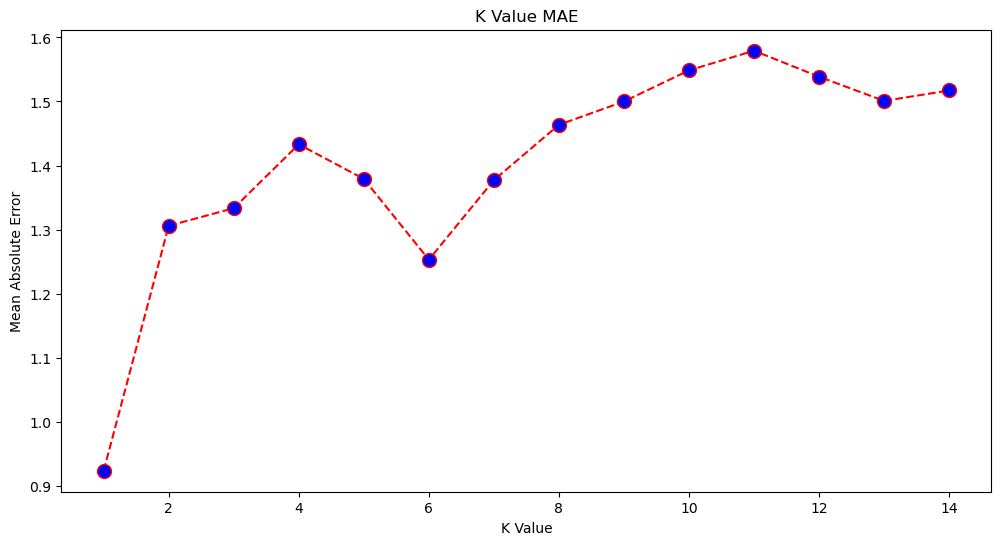

In [111]:
# @title
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error[:14], color='red',
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

En los gráficos se puede observar que el valor ´´optimo es 1

Fuente https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

In [112]:
# @title
############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 1

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=neighbors, weights= 'distance')
regressor.fit(X_train, y_train)



y_pred = regressor.predict(X_test)



############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
#knn_regressor.fit(coords_temp_train, value_temp_train)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
reg_score=regressor.score(X_test, y_test)
print("KNN out-of-sample r-squared: {}".format(round(reg_score, 2)))
print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'reg score: {reg_score}')

KNN out-of-sample r-squared: 0.9
mae: 0.9235444318680539
mse: 1.5149909006943287
rmse: 1.2308496661633088
reg score: 0.902849103413826


In [117]:
# @title
isocontornos_comunes = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
isocontornos = [-20,-15,-10, -5, 0, 5,7.5, 10,12.5, 15,17.5,20,22.5,25,27.5, 30, 35]
isocontornos_invertidos = isocontornos[::-1]
def plot_with_country_knn(x, y, z, grid, Isocontornos=None, country_boundaries=None, margin_scale=0.1, ax=None):
    """ Plot the input points, result, and country boundaries with a specified margin """

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen en el eje especificado (ax)
    im = ax.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan en el eje especificado (ax)

    if Isocontornos is not None:
        contours = ax.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), levels=Isocontornos, linewidths=.5, colors='black')
        #ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=ax, color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    scatter = ax.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=15)

    # Agregar una barra de color para la escala de colores
    plt.colorbar(scatter, ax=ax)

    # Ajustar los límites del eje según el bounding box ajustado con margen
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Quitar etiquetas de los ejes x e y
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

In [114]:
# @title
#Grilla
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

In [115]:
# @title
def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

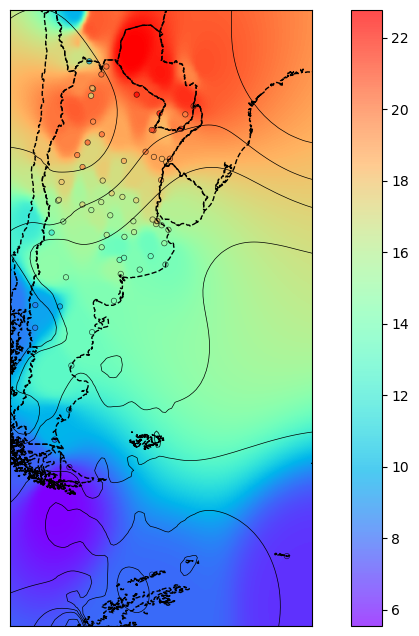

In [118]:
# @title
neighbors_values = 1  # Puedes ajustar estos valores según sea necesario

x_knn = df_filtered['long'].values
y_knn = df_filtered['lat'].values
z_knn = df_filtered['Temperatura_(C)'].values

dfC= pd.DataFrame(columns = ['x','y'])
dfC['x'] = xi
dfC['y'] = yi


# Genera el grid interpolado con el modelo KNN
grid2 = knn(dfC, regressor)
grid2 = grid1.reshape((ny, nx))

fig, ax = plt.subplots()
    # Utiliza la misma función para ambos tipos de gráficos
plot_with_country_knn(x_knn, y_knn, z_knn, grid2, Isocontornos=isocontornos,
                       country_boundaries=country_boundaries, margin_scale=0.1,ax=ax)
fig.set_size_inches(10, 8)

# Muestra la figura
plt.show()

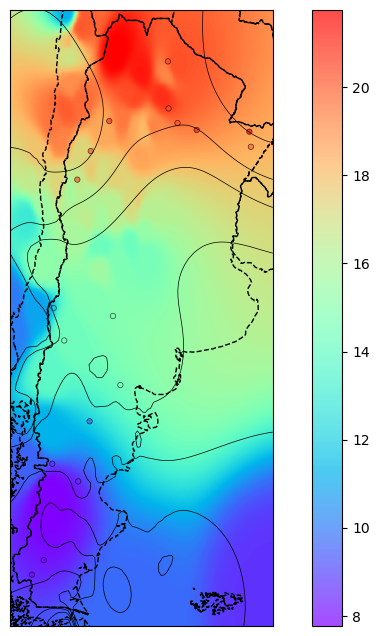

In [119]:
# @title
#nuevas_estaciones = gpd.read_file('/content/drive/My Drive/datasets_colab/final/nuevas_estaciones_knn.gpkg')
nuevas_estaciones = gpd.read_file('nuevas_estaciones_knn.gpkg')

nuevas_estaciones_filtered = nuevas_estaciones[['lat', 'long', 'Temperatura_(C)']]#
coords_temp = nuevas_estaciones_filtered[['long','lat']].values
value_temp = nuevas_estaciones_filtered['Temperatura_(C)'].values

y_pred=regressor.predict(coords_temp)


x_knn=nuevas_estaciones_filtered[['long']].values
y_knn=nuevas_estaciones_filtered[['lat']].values
z_knn=y_pred

fig, ax = plt.subplots()
    # Utiliza la misma función para ambos tipos de gráficos
plot_with_country_knn(x_knn, y_knn, z_knn, grid1, Isocontornos=isocontornos,
                       country_boundaries=country_boundaries, margin_scale=0.1,ax=ax)
fig.set_size_inches(10, 8)

# Muestra la figura
plt.show()




In [72]:
# @title
nuevas_estaciones_filtered.head()

,lat,long,Temperatura_(C)
0,-27.224837,-66.928694,None
1,-44.687639,-70.852913,None
2,-45.586868,-69.068941,None
3,-42.522203,-68.284138,None
4,-36.753092,-70.763214,None


In [120]:
# @title
nuevas_estaciones_filtered['Temperatura_(C)']=z_knn
nuevas_estaciones_filtered

/tmp/ipykernel_741/2899983389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevas_estaciones_filtered['Temperatura_(C)']=z_knn


,lat,long,Temperatura_(C)
0,-27.224837,-66.928694,20.725000
1,-44.687639,-70.852913,8.441667
2,-45.586868,-69.068941,8.441667
3,-42.522203,-68.284138,9.425000
4,-36.753092,-70.763214,11.900000
5,-38.407438,-70.033106,14.733333
6,-40.676352,-66.166517,14.733333
7,-26.583953,-62.847050,20.383333
8,-27.327815,-62.225193,20.383333
9,-28.537236,-57.171350,19.825000


#Cluster Jerárquico

Vamos a realizar análisis de cluster para ver si podemos clasificar las estaciones en "zonas climatológicas". La decisión de utilizar éste método se debe a que no tenemos en claro la cantidad de conglomerados que queremos tener.

/tmp/ipykernel_741/323584800.py:44: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


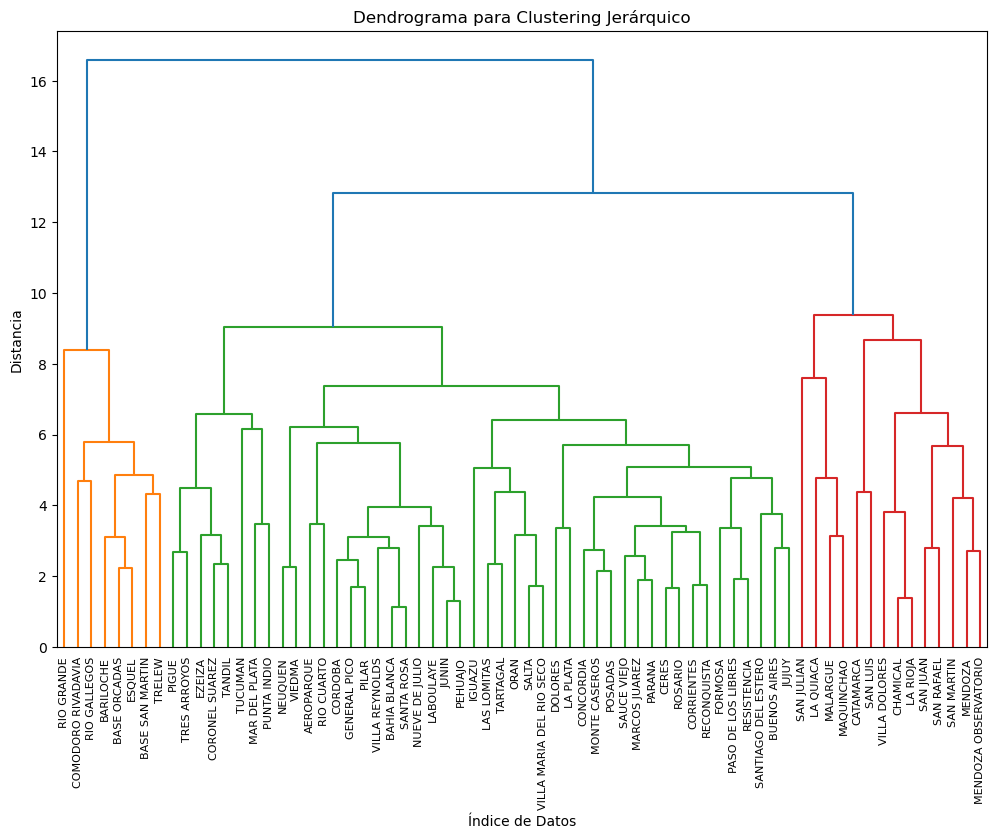

In [121]:
# @title
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram

variables_clustering = gdf_median.groupby('Estacion')[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
                                               'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
                                               'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
                                               'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Puedes realizar operaciones de agregación o análisis en los grupos si es necesario
# Por ejemplo, calcular la media de cada columna para cada estación
variables_clustering = variables_clustering.mean()



variables_clustering = variables_clustering[['Temperatura_(C)', 'Velocidad_del_Viento_(km/h)',
                                             'Nubosidad_total_(octavos)',
                            'Humedad_relativa_(%)']]


normalized_data = (variables_clustering - variables_clustering.mean()) / variables_clustering.std()


# Realizar clustering jerárquico
Z_single = linkage(normalized_data, method='single', metric='euclidean')
Z_complete = linkage(normalized_data, method='complete', metric='euclidean')
Z_average = linkage(normalized_data, method='average', metric='euclidean')

# Obtener asignaciones de clusters
num_clusters = 18
clusters_single = fcluster(Z_single, num_clusters, criterion='maxclust')
clusters_complete = fcluster(Z_complete, num_clusters, criterion='maxclust')
clusters_average = fcluster(Z_average, num_clusters, criterion='maxclust')


# Calcular las distancias entre los puntos (puedes ajustar la métrica según tus necesidades)
distances = pdist(normalized_data, metric='euclidean')

# Convertir las distancias a una matriz cuadrada
distance_matrix = squareform(distances)

# Calcular el enlace para el dendrograma
linkage_matrix = linkage(distance_matrix, method='average')
#linkage_matrix =Z_average
# Visualizar el dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=normalized_data.index, orientation='top', leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrograma para Clustering Jerárquico')
plt.xlabel('Índice de Datos')
plt.ylabel('Distancia')
plt.show()


In [75]:
normalized_data

,Temperatura_(C),Velocidad_del_Viento_(km/h),Nubosidad_total_(octavos),Humedad_relativa_(%)
Estacion,,,,
AEROPARQUE,0.427832,1.126733,-0.259023,0.501960
BAHIA BLANCA,-0.217173,NaN,0.028131,-0.400047
BARILOCHE,-1.962236,1.568599,0.550230,-0.309060
BASE ORCADAS,-2.377628,1.467665,0.002026,NaN
BASE SAN MARTIN,-2.064518,1.869158,0.002026,NaN
...,...,...,...,...
TUCUMAN,0.845312,-0.221294,2.012106,0.448042
VIEDMA,-0.498971,NaN,-0.624492,-0.881941
VILLA DOLORES,0.530115,-1.481846,-0.989961,-0.922379


Method: single-linkage


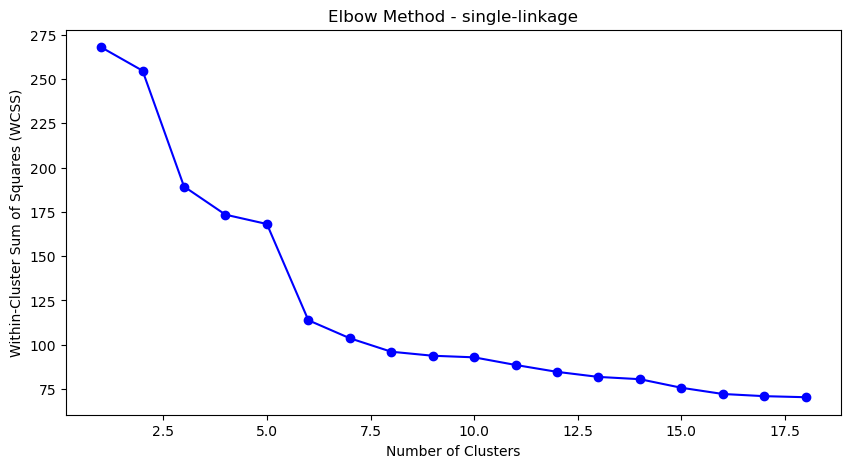


------

Method: complete-linkage


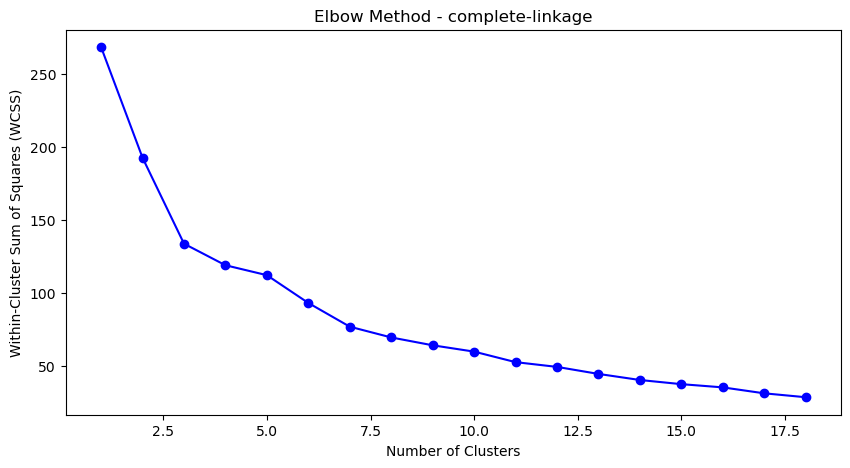


------

Method: average-linkage


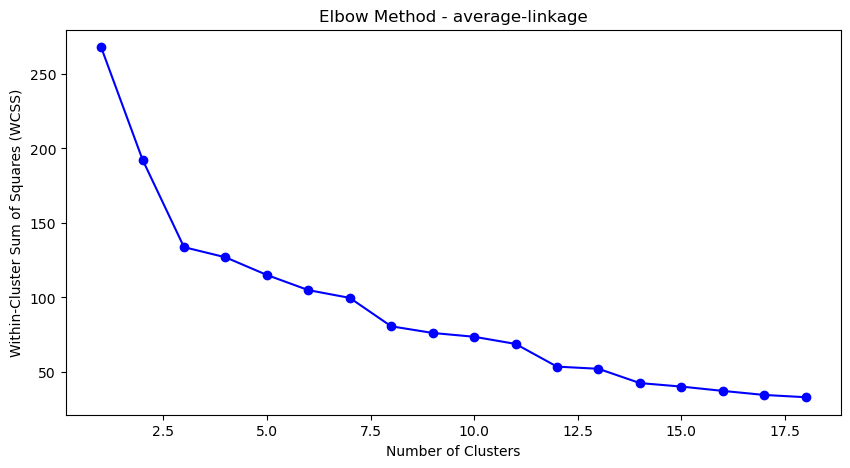


------



In [122]:
# @title
for method, clusters in [('single', clusters_single), ('complete', clusters_complete), ('average', clusters_average)]:
    print(f"Method: {method}-linkage")

    # Calcular WCSS para diferentes números de clústeres
    wcss_values = []
    for k in range(1, num_clusters + 1):
        clusters = fcluster(linkage(normalized_data, method=method, metric='euclidean'), k, criterion='maxclust')
        cluster_centers = pd.DataFrame(index=range(1, k + 1), columns=normalized_data.columns)
        for i in range(1, k + 1):
            cluster_data = normalized_data[clusters == i].mean()
            cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(variables_clustering.columns)
        ssw = ((normalized_data - normalized_data.groupby(clusters).transform('mean')) ** 2).sum().sum()
        wcss_values.append(ssw)

    # Visualizar el diagrama de codo
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_clusters + 1), wcss_values, marker='o', linestyle='-', color='b')
    plt.title(f'Elbow Method - {method}-linkage')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()

    print("\n------\n")

Una de las características del método simple es que cuando no hay mucha distancia entre los cluster puede haber bastante ruido. Éste tipo de método tiene mejores resultados con bastante distancia intercluster.

El método Complete o de máxima distancia tiene un compartamiento totalmente inverso al simple.Si hay poca diferencia entre los cluster, el aglomerado es mejor
La aproximación MAX tiene un buen desempeño al separar cúmulos si hay ruido entre ellos. Como contra : La aproximación "Max" está sesgada hacia los cúmulos globulares.
La aproximación "Max" tiende a dividir los cúmulos grandes.

Pros de la aproximación de Grupo Promedio:

    La aproximación de Grupo Promedio tiene un buen desempeño al separar cúmulos si hay ruido entre ellos.

Contras de la aproximación de Grupo Promedio:

    La aproximación de Grupo Promedio está sesgada hacia los cúmulos globulares.
    Distancia entre centroides: Calcular los centroides de dos cúmulos C1 y C2 y tomar la similitud entre los dos centroides como la similitud entre dos cúmulos. Esta es una técnica menos popular en el mundo real.

In [123]:
# @title
# Obtener asignaciones de clusters
##########################################################
##########################################################
##########################################################
num_clusters = 7
##########################################################
##########################################################
##########################################################


clusters_single = fcluster(Z_single, num_clusters, criterion='maxclust')
clusters_complete = fcluster(Z_complete, num_clusters, criterion='maxclust')
clusters_average = fcluster(Z_average, num_clusters, criterion='maxclust')


# Calcular las distancias entre los puntos (puedes ajustar la métrica según tus necesidades)
distances = pdist(normalized_data, metric='euclidean')

# Convertir las distancias a una matriz cuadrada
distance_matrix = squareform(distances)

# Calcular el enlace para el dendrograma
linkage_matrix = linkage(distance_matrix, method='average')

# Mostrar los centros de los clusters sin Normalizar
cluster_centers = pd.DataFrame(index=range(1, num_clusters + 1), columns=variables_clustering.columns)
for i in range(1, num_clusters + 1):
    cluster_data = variables_clustering[clusters_average == i].mean()
    cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(variables_clustering.columns) else [np.nan] * len(variables_clustering.columns)

print("Number of clusters:", num_clusters)
print("Transformation: Standardize (Z)")
print("Method: Average-linkage")
print("Distance function: Euclidean")
print("\nCluster centers:")
print(cluster_centers)

# Mostrar los centros de los clusters Normalizados
cluster_centers = pd.DataFrame(index=range(1, num_clusters + 1), columns=normalized_data.columns)
for i in range(1, num_clusters + 1):
    cluster_data = normalized_data[clusters_average == i].mean()
    cluster_centers.loc[i, :] = cluster_data.values if len(cluster_data) == len(normalized_data.columns) else [np.nan] * len(normalized_data.columns)

print("Number of clusters:", num_clusters)
print("Transformation: Standardize (Z)")
print("Method: Average-linkage")
print("Distance function: Euclidean")
print("\nCluster centers:")
print(cluster_centers)

# Calcular métricas adicionales
wcss_values = []
for k in range(1, num_clusters + 1):
    cluster_data = normalized_data[clusters_average == k]
    ssw = ((cluster_data - cluster_data.mean(axis=0)) ** 2).sum().sum()
    wcss_values.append(ssw)

sst = ((normalized_data - normalized_data.mean()) ** 2).sum().sum()
bcss = sst - sum(wcss_values)

print("\nThe total sum of squares:", sst)
print("Within-cluster sum of squares:")
for i, wcss in enumerate(wcss_values):
    print(f"C{i + 1} : {wcss}")
print("\nThe total within-cluster sum of squares:", sum(wcss_values))
print("The between-cluster sum of squares:", bcss)
print("The ratio of between to total sum of squares:", bcss / sst)

Number of clusters: 7
Transformation: Standardize (Z)
Method: Average-linkage
Distance function: Euclidean

Cluster centers:
  Temperatura_(C) Velocidad_del_Viento_(km/h) Nubosidad_total_(octavos)  \
1       13.316667                     18.9375                    4.1875   
2        8.168056                   16.602778                  3.940278   
3            5.55                   15.741667                  4.208333   
4         17.5375                   11.092693                  3.746565   
5         19.0375                       17.05                     3.325   
6       10.377778                    8.433333                  3.558333   
7       17.635417                    8.357483                  3.196875   

  Humedad_relativa_(%)  
1            55.533333  
2            62.021944  
3            78.841667  
4            72.297177  
5            55.804167  
6            57.844444  
7            59.051042  
Number of clusters: 7
Transformation: Standardize (Z)
Method: Average-link

/tmp/ipykernel_741/4190317318.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


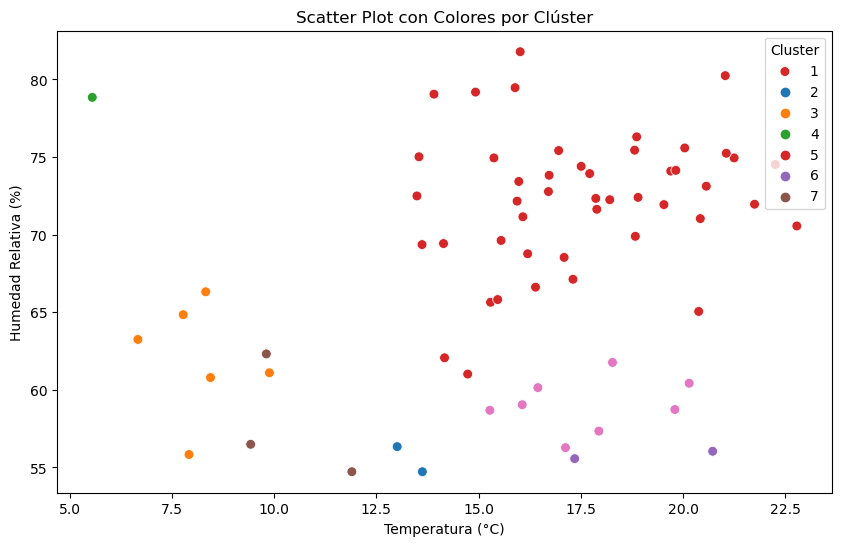

In [124]:
# @title
# Agregar la columna 'Cluster' al DataFrame variables_clustering
variables_clustering['Cluster'] = clusters_average

# Scatter plot con colores por clúster
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=variables_clustering, x='Temperatura_(C)', y='Humedad_relativa_(%)', hue='Cluster', palette='tab10', s=50)

# Personalizar la leyenda para incluir todos los números de clúster únicos
unique_labels = sorted(variables_clustering['Cluster'].unique())

# Mostrar todos los números de clúster en la leyenda
plt.legend(title='Cluster', loc='upper right', labels=unique_labels)

plt.title('Scatter Plot con Colores por Clúster')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Humedad Relativa (%)')
plt.show()

In [125]:
# @title
gdf_jerarquico = gdf_median.groupby(['Estacion'])[['lat', 'long']].mean()
gdf_jerarquico['Estacion']= gdf_jerarquico.index
gdf_jerarquico = gdf_jerarquico.rename_axis('n')

variables_clustering['Estacion']= variables_clustering.index
variables_clustering = variables_clustering.rename_axis('Estacion')
variables_clustering = variables_clustering.rename_axis('n')


#variables_clustering.set_index('Estacion', inplace=True)


gdf_jerarquico['Estacion'] = gdf_jerarquico['Estacion'].str.strip()  # Eliminar espacios adicionales si los hubiera

# Fusionar gdf_jerarquico con variables_clustering
gdf_jerarquico = gdf_jerarquico.merge(variables_clustering[['Cluster']], left_on='Estacion', right_index=True, how='left')



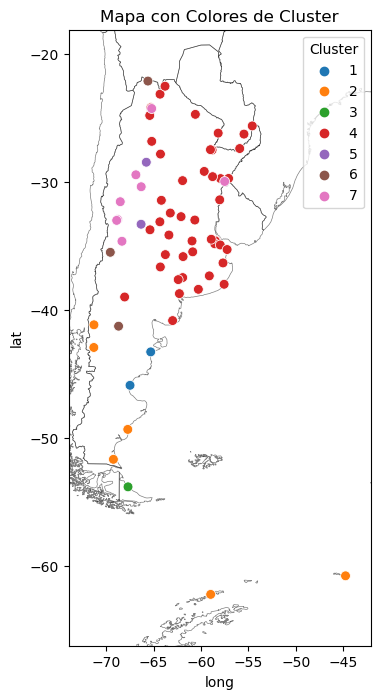

In [126]:
# @title
mapeo = gpd.GeoDataFrame(gdf_jerarquico,
                         geometry=gpd.points_from_xy(gdf_jerarquico['long'],
                                                                gdf_jerarquico['lat']))
# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

pais.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5, facecolor='none')

# Colores automáticos basados en la cantidad de clusters
palette = sns.color_palette("tab10", n_colors=len(gdf_jerarquico['Cluster'].unique()))
sns.scatterplot(data=gdf_jerarquico, x='long', y='lat', hue='Cluster', palette=palette, ax=ax, s=50)


# Ajustar los límites del gráfico
x_min, y_min, x_max, y_max = mapeo.total_bounds
margin_scale = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min_adjusted = x_min - margin_scale * x_range
x_max_adjusted = x_max + margin_scale * x_range
y_min_adjusted = y_min - margin_scale * y_range
y_max_adjusted = y_max + margin_scale * y_range
ax.set_xlim(x_min_adjusted, x_max_adjusted)
ax.set_ylim(y_min_adjusted, y_max_adjusted)
# Mostrar el mapa
plt.title('Mapa con Colores de Cluster')
plt.legend(title='Cluster')
plt.show()

# Cluster KMeans

In [127]:
# @title
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


variables_clustering = gdf_median.groupby('Estacion')[['Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
                                               'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
                                               'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
                                               'Frecuencia_dias_Precipitacion_>0.1_mm']]

# Puedes realizar operaciones de agregación o análisis en los grupos si es necesario
# Por ejemplo, calcular la media de cada columna para cada estación
variables_clustering = variables_clustering.mean()


normalized_data = (variables_clustering - variables_clustering.mean()) / variables_clustering.std()


# Selecciona las columnas relevantes para el análisis de k-means
data_for_kmeans = normalized_data



# Especifica el número de clústeres (k) que deseas encontrar
k = 7

# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, random_state=42)
gdf_jerarquico['Cluster_kmean'] = kmeans.fit_predict(data_for_kmeans)


# Selecciona las columnas relevantes para el análisis de k-means


data_for_kmeans = variables_clustering[['Temperatura_(C)', 'Velocidad_del_Viento_(km/h)',
                                             'Nubosidad_total_(octavos)',
                            'Humedad_relativa_(%)']]



# Crea y ajusta el modelo k-means
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=150, max_iter=1000, random_state=42)
variables_clustering['Cluster_kmean'] = kmeans.fit_predict(data_for_kmeans)

# Resultados del análisis de k-means
cluster_centers = kmeans.cluster_centers_
within_cluster_ss = np.zeros((k, 1))

for i in range(k):
    cluster_data = data_for_kmeans[variables_clustering['Cluster_kmean'] == i]
    within_cluster_ss[i, 0] = np.sum((cluster_data.values - cluster_centers[i:i+1, :]) ** 2)

total_within_cluster_ss = within_cluster_ss.sum()
total_sum_of_squares = np.sum((data_for_kmeans.values - np.mean(data_for_kmeans.values)) ** 2)
between_cluster_ss = total_sum_of_squares - total_within_cluster_ss
ratio_between_to_total_ss = between_cluster_ss / total_sum_of_squares

# Mostrar resultados
print("Cluster centers:")
print(pd.DataFrame(cluster_centers, columns=data_for_kmeans.columns))
print("\nWithin-cluster sum of squares:")
print(pd.DataFrame(within_cluster_ss, columns=['Within cluster S.S.']))
print("\nThe total within-cluster sum of squares:", total_within_cluster_ss)
print("The between-cluster sum of squares:", between_cluster_ss)
print("The ratio of between to total sum of squares:", ratio_between_to_total_ss)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster centers:
   Temperatura_(C)  Velocidad_del_Viento_(km/h)  Nubosidad_total_(octavos)  \
0        19.305903                     9.964095                   3.713556   
1        12.170238                    10.095007                   3.569048   
2        15.726282                    12.336703                   3.776923   
3        16.530000                    16.943333                   3.591667   
4        13.601190                    13.440476                   3.907143   
5         7.825000                    17.663333                   3.893333   
6        18.321429                     7.494278                   3.354762   

   Humedad_relativa_(%)  
0             73.710562  
1             59.485714  
2             69.157051  
3             56.003333  
4             78.326190  
5             62.206332  
6             60.204762  

Within-cluster sum of squares:
   Within cluster S.S.
0           302.596449
1           110.440468
2           134.089180
3            72.279944
4  

# PCA

In [131]:
gdf_median.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Unnamed: 0                             840 non-null    int64   
 1   Estacion                               840 non-null    object  
 2   mes                                    840 non-null    object  
 3   lat                                    840 non-null    float64 
 4   long                                   840 non-null    float64 
 5   Altura_(m)                             840 non-null    int64   
 6   Numero                                 840 non-null    int64   
 7   Temperatura_(C)                        840 non-null    float64 
 8   Temperatura_maxima_(C)                 840 non-null    float64 
 9   Temperatura_minima_(C)                 840 non-null    float64 
 10  Humedad_relativa_(%)                   840 non-null   

Varianza explicada por cada PC:
[0.5029618  0.2292287  0.14268381 0.07118705 0.03864481 0.01141045
 0.00388336]
Hereogeneidad: 7 PCs rescatan individualmente una heterogeneidad mayor al 20%
Cantidad de Pcs: 2 PCs explican en conjunto una heterogeneidad mayor al 70.0%
Cantidad de Pcs: 3 PCs explican en conjunto una heterogeneidad mayor al 80.0%
Cantidad de Pcs: 4 PCs explican en conjunto una heterogeneidad mayor al 90.0%
Cantidad de Pcs: 5 PCs explican en conjunto una heterogeneidad mayor al 95.0%
Correlación entre las variables originales seleccionadas y las PC:
                             PC1       PC2       PC3       PC4       PC5  \
Temperatura_maxima_(C) -0.508337  0.112016  0.013822  0.199641  0.118833   
Precipitacion_(mm)     -0.368804 -0.401210  0.262702 -0.313822 -0.731669   

                             PC6       PC7  
Temperatura_maxima_(C)  0.727252 -0.382076  
Precipitacion_(mm)      0.009592  0.009276  


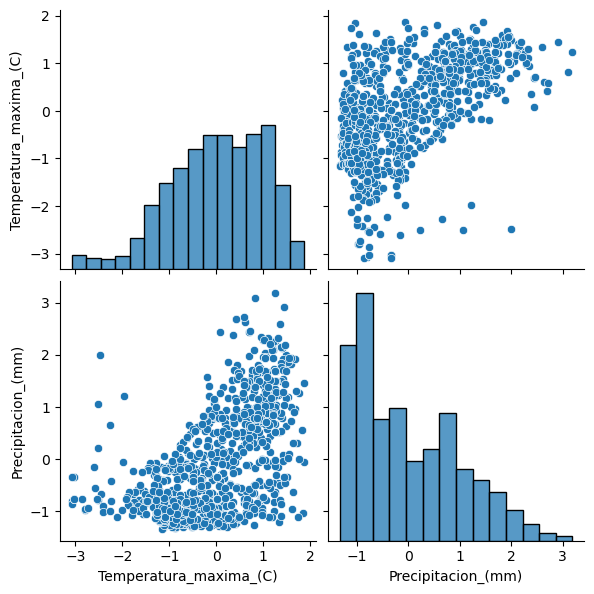

In [148]:
#gdf = gpd.read_file("gdf_median.gpkg")
#Leer archivo GeoPackage
#gdf = gpd.read_file("gdf_median.gpkg")

# Leer archivo GeoPackage
gdf = gdf_median

# Seleccionar las variables para el análisis de componentes principales
variables = ["Temperatura_(C)", "Temperatura_maxima_(C)", "Temperatura_minima_(C)", "Humedad_relativa_(%)", "Velocidad_del_Viento_(km/h)", "Nubosidad_total_(octavos)", "Precipitacion_(mm)"]

# Estandarizar los datos antes de aplicar PCA
scaler = StandardScaler()
gdf[variables] = scaler.fit_transform(gdf[variables])

# Aplicar PCA
pca = PCA()
gdf_pca = pd.DataFrame(pca.fit_transform(gdf[variables]), columns=[f"PC{i+1}" for i in range(len(variables))])

# Mostrar la varianza explicada por cada PC
explained_variance_ratio = pca.explained_variance_ratio_
print("Varianza explicada por cada PC:")
print(explained_variance_ratio)

# Pregunta 1: Contar cuántas PC rescatan individualmente una heterogeneidad original mayor al 20%
pc_cumsum = np.cumsum(explained_variance_ratio)
pc_above_threshold = len(pc_cumsum[pc_cumsum > 0.2])
print(f"Hereogeneidad: {pc_above_threshold} PCs rescatan individualmente una heterogeneidad mayor al 20%")

# Preguntas 2: Cuántas PCs explican en conjunto una heterogeneidad mayor al 70%, 80%, 90% y 95%
thresholds = [0.7, 0.8, 0.9, 0.95]
for threshold in thresholds:
    pc_to_reach_threshold = np.argmax(pc_cumsum > threshold) + 1
    print(f"Cantidad de Pcs: {pc_to_reach_threshold} PCs explican en conjunto una heterogeneidad mayor al {threshold*100}%")

# Seleccionar dos variables originales que mejor se correlacionen con las PC1, PC2 y PC3
selected_variables = ["Temperatura_maxima_(C)", "Precipitacion_(mm)"]  # Ajustar según tus necesidades

# Calcular la matriz de correlación entre las PC y las variables originales seleccionadas
correlation_matrix = pd.DataFrame(pca.components_.T, index=gdf[variables].columns, columns=[f"PC{i+1}" for i in range(len(variables))])
selected_variables_correlation = correlation_matrix.loc[selected_variables]

# Mostrar las correlaciones
print("Correlación entre las variables originales seleccionadas y las PC:")
print(selected_variables_correlation)

# Graficar scatterplots
sns.pairplot(gdf, vars=selected_variables, height=3)
plt.show()


